In [1]:
%config IPCompleter.greedy=True

import tensorflow as tf
import numpy as np
import cv2
import classification_models
import os
import shutil

from tensorflow import keras
from matplotlib import pyplot as plt
from classification_models.tfkeras import Classifiers

# Mise en place de la caméra

### Recherche de la caméra

In [2]:
!ls -ltrh /dev/video*

crw-rw----+ 1 root video 81, 0 sept.  1 23:37 /dev/video0
crw-rw----+ 1 root video 81, 4 sept.  1 23:37 /dev/video1


### Définition de la classe Camera

In [3]:
import traitlets
import threading
import atexit
import numpy as np


class Camera(traitlets.HasTraits):
    type_camera = traitlets.Unicode("CSI")
    capture_device = traitlets.Integer(default_value=0)
    capture_width = traitlets.Integer(default_value=1280)
    capture_height = traitlets.Integer(default_value=720)
    display_width = traitlets.Integer(default_value=640)
    display_height = traitlets.Integer(default_value=480)
    fps = traitlets.Integer(default_value=30)
    flip = traitlets.Integer(default_value=0)
    image = traitlets.Any()
    video_on = traitlets.Bool(default_value=False)
    
    def __init__(self,*args,**kwargs):
        super(Camera, self).__init__(*args, **kwargs)
        self._running = False
        self.image = np.empty((self.display_height, self.display_width, 3), dtype=np.uint8)
        
        if self.type_camera.find("CSI")>=0:
            self.cap = cv2.VideoCapture(self._gstreamer_pipeline_CSI(),cv2.CAP_GSTREAMER)
        else:
            self.cap = cv2.VideoCapture(self._gstreamer_pipeline_USB(),cv2.CAP_GSTREAMER)

        if self.cap.isOpened():
            print("Caméra initialisée")
        else:
            print("Erreur d'ouverture du flux vidéo")
        atexit.register(self.cap.release)
    
    # Lecture d'une frame
    def capture_image(self):
        re, image = self.cap.read()
        if re:
            image_resized = cv2.resize(image,(int(self.display_width),int(self.display_height)))
        return image_resized
    
    # ON/OFF de la capture vidéo
    def capture_video(self,run=False):
        if run is True:
            self.video_on = True
        else:
            self.video_on = False
    
    # Lecture d'un flux vidéo
    def _capture_video(self):
        while True:
            if not self._running:
                break
            self.image = self.capture_image()

            
    # Détachement de la caméra
    def release(self):
        self.cap.release()

    # Définition du pipeline pour la caméra CSI
    def _gstreamer_pipeline_CSI(self):
        return("nvarguscamerasrc sensor-id=%d ! "
                "video/x-raw(memory:NVMM),"
                "width=(int)%d,height=(int)%d,"
                "format=(string)NV12, framerate=(fraction)%d/1 ! "
                "nvvidconv flip-method=%d ! "
                "video/x-raw,"
                "width=(int)%d,height=(int)%d,"
                "format=(string)BGRx ! videoconvert ! "
                "video/x-raw, format=(string)BGR ! "
                "appsink drop=true"
        %(self.capture_device,self.capture_width,self.capture_height,self.fps,self.flip, self.display_width,self.display_height))

    # Définition du pipeline pour la USB
    def _gstreamer_pipeline_USB(self):
        return("v4l2src device=/dev/video%d ! "
               "video/x-raw, width=(int)%d, height=(int)%d, framerate=(fraction)%d/1 ! "
               "videoflip method=%d ! "
               "videoconvert ! "
               "video/x-raw, format=(string)BGR ! appsink drop=true"
        %(self.capture_device,self.capture_width,self.capture_height,self.fps,self.flip))
    
    # Surveillance de la variable "video_on"
    @traitlets.observe('video_on')
    def _on_running(self, change):
        if change['new'] and not change['old']:
            # not running -> running
            self._running = True
            self.thread = threading.Thread(target=self._capture_video)
            self.thread.start()
        elif change['old'] and not change['new']:
            # running -> not running
            self._running = False
            self.thread.join()

### Instanciation de la classe Camera

In [4]:
def InitCamera():
    camera = Camera(type_camera="USB",capture_device=1,
                capture_width=640,capture_height=480,
                display_width=320,display_height=200,
                fps=30,flip=0)
    return camera

# Création des données d'entrainement

### Acquisition des images

On commence par créer une interface à l'aide des widgets permettant de récupérer les données et de les sauvegarder dans un dictionnaire :

In [5]:
def bgr8_to_jpeg(value, quality=75):
    return bytes(cv2.imencode('.jpg', value)[1])

In [6]:
TACHE = "pouce"
CATEGORIES = ['pouce_haut', 'pouce_bas']
datasets = {}
for name in CATEGORIES:
    datasets[name] = []

In [7]:
import ipywidgets
import traitlets
from IPython.display import display


# Initialise la caméra
try :
    camera.capture_video(run=False)
    camera.release()
    del camera
except NameError:
    pass

camera = InitCamera()

# Création du widget de la vidéo
camera_widget = ipywidgets.Image()
traitlets.dlink((camera, 'image'), (camera_widget, 'value'), transform=bgr8_to_jpeg)

# Création des widgets de l'interface
category_widget = ipywidgets.Dropdown(options=CATEGORIES, description='Catégorie')
count_widget = ipywidgets.IntText(description='Nombre')
save_widget = ipywidgets.Button(description='Ajouter')

# Mise à jour du nombre de données dans les catégories
def update_counts(change):
    count_widget.value = len(datasets[change['new']])
count_widget.value = len(datasets[category_widget.value])
category_widget.observe(update_counts, names='value')

# Prise d'une image
def save(c):
    datasets[category_widget.value].append(camera.image)
    count_widget.value = len(datasets[category_widget.value])
save_widget.on_click(save)

data_collection_widget = ipywidgets.VBox([
    ipywidgets.HBox([camera_widget]), category_widget, count_widget, save_widget])

# Lancement de la vidéo
camera.capture_video(run=True)
camera_link = traitlets.dlink((camera, 'image'), (camera_widget, 'value'), transform=bgr8_to_jpeg)

# Affiche l'interface
display(data_collection_widget)

Caméra initialisée


Widget Javascript not detected.  It may not be installed or enabled properly.


### Sauvegarde des images

Les données sont sauvegardées en respectant la structure requise par la fonction tf.keras.preprocessing.image_dataset_from_directory : https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [8]:
repertoire_courant = os.getcwd()

In [10]:
# Création des répertoires de sauvegarde
try:
    shutil.rmtree(repertoire_courant+"/projet_classification/"+TACHE)
except FileNotFoundError:
    pass

try:
    shutil.rmtree(repertoire_courant+"/projet_classification/"+TACHE+"/"+CATEGORIES[0])
except FileNotFoundError:
    pass
os.makedirs(repertoire_courant+"/projet_classification/"+TACHE+"/"+CATEGORIES[0])

try:
    shutil.rmtree(repertoire_courant+"/projet_classification/"+TACHE+"/"+CATEGORIES[1])
except FileNotFoundError:
    pass
os.makedirs(repertoire_courant+"/projet_classification/"+TACHE+"/"+CATEGORIES[1])

In [11]:
# Enregistrement des images
n = 0
for image in datasets[CATEGORIES[0]]:
    n = n+1
    cv2.imwrite(repertoire_courant+"/projet_classification/"+TACHE+"/"+CATEGORIES[0]+"/"+CATEGORIES[0]+"_image_%d.jpg" %n,image)

n = 0
for image in datasets[CATEGORIES[1]]:
    n = n+1
    cv2.imwrite(repertoire_courant+"/projet_classification/"+TACHE+"/"+CATEGORIES[1]+"/"+CATEGORIES[1]+"_image_%d.jpg" %n,image)

# Création des datasets

### Chargement des images dans le dataset d'entrainement

A partir des images sauvegardées dans le répertoire de travail, on peut maintenant créer notre dataset :

In [35]:
dataset_entrainement = tf.keras.preprocessing.image_dataset_from_directory(
    repertoire_courant+"/projet_classification/"+TACHE,
    validation_split=0.0,
    image_size=(224, 224),
    batch_size=5,
    label_mode='categorical')

Found 60 files belonging to 2 classes.


In [32]:
class_names = dataset_entrainement.class_names
print(class_names)

['pouce_bas', 'pouce_haut']


Regardons le format du tenseur contenu dans le dataset :

In [11]:
for image,label in dataset_entrainement.take(2):
    print(image.shape)
    print(label.shape)

(5, 224, 224, 3)
(5, 2)
(5, 224, 224, 3)
(5, 2)


Regardons comment est codée une image :

In [12]:
for image,label in dataset_entrainement.take(1):
    print(image[0])

tf.Tensor(
[[[168.42857  180.42857  178.42857 ]
  [170.       182.       180.      ]
  [168.92857  180.92857  178.92857 ]
  ...
  [175.14282  185.92859  172.      ]
  [177.35715  188.35715  173.64285 ]
  [177.21426  188.21426  172.21426 ]]

 [[168.90816  180.90816  178.90816 ]
  [169.70026  181.70026  179.70026 ]
  [168.98853  180.98853  178.98853 ]
  ...
  [177.54082  185.98853  172.83928 ]
  [176.75764  187.75764  173.64285 ]
  [175.53569  186.53569  170.89536 ]]

 [[170.3074   182.3074   181.77168 ]
  [169.90434  181.90434  181.36862 ]
  [169.10458  181.10458  180.56888 ]
  ...
  [178.       186.       174.46428 ]
  [177.11351  186.70154  173.1722  ]
  [176.3648   187.3648   172.94388 ]]

 ...

 [[ 48.603252  65.811165  79.21423 ]
  [ 78.476654  94.8708   105.138664]
  [151.82986  163.7087   171.80948 ]
  ...
  [ 82.62339   80.08903   55.69505 ]
  [ 51.913254  50.585472  35.06385 ]
  [ 53.465565  50.95793   44.083054]]

 [[ 72.9508    89.29135  101.20081 ]
  [157.43292  172.94058  1

Affichons quelques labels codé de manière "categorical" et leur valeur équivalente "binaire" :

In [13]:
for image,label in dataset_entrainement.take(3):
    print("Label categorical : %s" %label[0])
    print("Label binaire correspondant : %s" %np.argmax(label[0], axis=None, out=None))
    print("Classe correspondante : %s" %class_names[np.argmax(label[0], axis=None, out=None)])
    print("")

Label categorical : tf.Tensor([1. 0.], shape=(2,), dtype=float32)
Label binaire correspondant : 0
Classe correspondante : pouce_bas

Label categorical : tf.Tensor([1. 0.], shape=(2,), dtype=float32)
Label binaire correspondant : 0
Classe correspondante : pouce_bas

Label categorical : tf.Tensor([0. 1.], shape=(2,), dtype=float32)
Label binaire correspondant : 1
Classe correspondante : pouce_haut



Affichons maintenant quelques images :

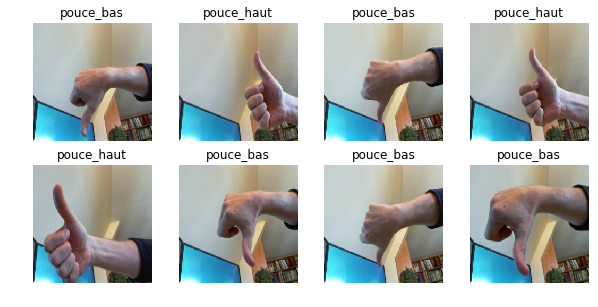

In [14]:
iterator = iter(dataset_entrainement)

plt.figure(figsize=(10, 10))
for i in range(8):
    ax = plt.subplot(4, 4, i + 1)
    image, label = iterator.get_next()
    plt.imshow(image[0].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(label[0], axis=None, out=None)])
    plt.axis("off")

### Traitement des images

On applique les transformations suivantes sur les images :
    - Modifie la luminosité de manière aléatoire avec une valeur comprise entre [-0.2;+0.2]
    - Modifie le contraste de manière aléatoire avec un facteur compris entre [0.8;1.2]
    - Modifie la saturation de manière aléatoire avec un facteur compris entre [0.8;1.2]
    - Modifie la teinte de manière aléatoire avec un facteur compris entre [-0.2;+0.2]    

In [15]:
dataset_entrainement = dataset_entrainement.map(lambda x,y: (tf.image.random_brightness(tf.cast(x,dtype="uint8"),0.2),y))
dataset_entrainement = dataset_entrainement.map(lambda x,y: (tf.image.random_contrast(x,0.8,1.2),y))
dataset_entrainement = dataset_entrainement.map(lambda x,y: (tf.image.random_saturation(x,0.8,1.2),y))
dataset_entrainement = dataset_entrainement.map(lambda x,y: (tf.image.random_hue(x,0.2),y))

Enfin on convertit toutes les valeurs dans l'intervalle [0.0,1.0]:

In [16]:
dataset_entrainement = dataset_entrainement.map(
    lambda x,y: (tf.keras.layers.experimental.preprocessing.Rescaling(1.0/tf.reduce_max(tf.keras.layers.Flatten()(tf.cast(x,dtype="float32"))))
                 (tf.cast(x,dtype="float32")),y))

In [ ]:
tf.keras.applications.resnet50.preprocess_input

In [33]:
dataset_entrainement = dataset_entrainement.map(
    lambda x,y: (tf.keras.applications.resnet50.preprocess_input(x),y))

In [34]:
for image,label in dataset_entrainement.take(1):
    print(image[0])

tf.Tensor(
[[[ 87.061      73.221      45.32     ]
  [ 87.061      73.221      45.32     ]
  [ 88.13242    74.29243    46.462852 ]
  ...
  [ 82.061      79.221      55.32     ]
  [ 82.418144   79.57815    55.677147 ]
  [ 83.84673    81.00674    57.105736 ]]

 [[ 88.55973    74.719734   46.818733 ]
  [ 87.900276   74.06028    46.15928  ]
  [ 88.9717     75.13171    47.30213  ]
  ...
  [ 82.840355   80.00036    56.099358 ]
  [ 82.95768    80.11768    56.216682 ]
  [ 83.18728    80.34728    56.44628  ]]

 [[ 91.043144   75.00672    48.57     ]
  [ 90.25742    74.221      47.78428  ]
  [ 91.27656    75.240135   48.822548 ]
  ...
  [ 84.50616    79.469734   57.033012 ]
  [ 84.525276   79.48885    57.052147 ]
  [ 84.525276   79.48885    57.052147 ]]

 ...

 [[-20.547478  -44.030365  -81.86377  ]
  [ 11.725143  -10.845741  -40.431694 ]
  [ 81.036354   60.783073   41.865486 ]
  ...
  [-42.584553  -33.29843   -35.481308 ]
  [-60.820312  -64.47161   -67.640465 ]
  [-51.79996   -66.132416  -70.24

In [59]:
iterator = iter(dataset_entrainement)

plt.figure(figsize=(10, 10))
for i in range(8):
    ax = plt.subplot(4, 4, i + 1)
    image, label = iterator.get_next()
    plt.imshow((image[0].numpy()*255.0).astype("uint8"))
    plt.title(class_names[np.argmax(label[0], axis=None, out=None)])
    plt.axis("off")

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f335e5620> (for post_execute):


ValueError: Floating point image RGB values must be in the 0..1 range.

ValueError: Floating point image RGB values must be in the 0..1 range.

# Création du modèle

Pour utiliser le modèle RestNet18, nous allons utiliser le package Image-classifiers disponnible sur le github : https://github.com/AlexandreBourrieau/classification_models

### Resenet50

In [22]:
base_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet',
                                                     include_top=False,
                                                     input_shape=(224,224,3),
                                                     pooling=False)
model = tf.keras.models.Model(inputs=base_model.input, outputs=base_model.output)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [23]:
# Désactivation des couches poru l'entrainement
for layer in base_model.layers:
    layer.trainable = False

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [24]:
# Ajout de l'applatissement des sorties et de la couche dense avec 2 neurones"
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(units=2, activation='softmax')(x)
model = tf.keras.Model(inputs=[base_model.input], outputs=[output])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

conv5_block1_out (Activation)   (None, 7, 7, 2048)   0           conv5_block1_add[0][0]           
__________________________________________________________________________________________________
conv5_block2_1_conv (Conv2D)    (None, 7, 7, 512)    1049088     conv5_block1_out[0][0]           
__________________________________________________________________________________________________
conv5_block2_1_bn (BatchNormali (None, 7, 7, 512)    2048        conv5_block2_1_conv[0][0]        
__________________________________________________________________________________________________
conv5_block2_1_relu (Activation (None, 7, 7, 512)    0           conv5_block2_1_bn[0][0]          
__________________________________________________________________________________________________
conv5_block2_2_conv (Conv2D)    (None, 7, 7, 512)    2359808     conv5_block2_1_relu[0][0]        
__________________________________________________________________________________________________
conv5_bloc

In [25]:
# Liste des couches du modèle
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_2
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

In [26]:
for layer in model.layers[165:]:
   layer.trainable = True

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

### Restnet18

In [36]:
# Chargement du modèle ResNEt18
ResNet18, preprocess_input = Classifiers.get('resnet18')

# Instanciation du modèle pré-entrainé ResNet18
base_model = ResNet18(input_shape=(224,224,3), weights='imagenet', include_top=False,pooling=False)

model = tf.keras.models.Model(inputs=base_model.input, outputs=base_model.output)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_18 (ZeroPadding2 (None, 230, 230, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d_18[0][0]          
____________________________________________________________________________________________

In [37]:
# Désactivation des couches poru l'entrainement
for layer in base_model.layers:
    layer.trainable = False

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_18 (ZeroPadding2 (None, 230, 230, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d_18[0][0]          
____________________________________________________________________________________________

In [38]:
# Ajout de l'applatissement des sorties et de la couche dense avec 2 neurones"
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(units=2, activation='softmax')(x)
model = tf.keras.Model(inputs=[base_model.input], outputs=[output])
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_18 (ZeroPadding2 (None, 230, 230, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d_18[0][0]          
____________________________________________________________________________________________

In [39]:
# Liste des couches du modèle
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 data
1 bn_data
2 zero_padding2d_18
3 conv0
4 bn0
5 relu0
6 zero_padding2d_19
7 pooling0
8 stage1_unit1_bn1
9 stage1_unit1_relu1
10 zero_padding2d_20
11 stage1_unit1_conv1
12 stage1_unit1_bn2
13 stage1_unit1_relu2
14 zero_padding2d_21
15 stage1_unit1_conv2
16 stage1_unit1_sc
17 add_8
18 stage1_unit2_bn1
19 stage1_unit2_relu1
20 zero_padding2d_22
21 stage1_unit2_conv1
22 stage1_unit2_bn2
23 stage1_unit2_relu2
24 zero_padding2d_23
25 stage1_unit2_conv2
26 add_9
27 stage2_unit1_bn1
28 stage2_unit1_relu1
29 zero_padding2d_24
30 stage2_unit1_conv1
31 stage2_unit1_bn2
32 stage2_unit1_relu2
33 zero_padding2d_25
34 stage2_unit1_conv2
35 stage2_unit1_sc
36 add_10
37 stage2_unit2_bn1
38 stage2_unit2_relu1
39 zero_padding2d_26
40 stage2_unit2_conv1
41 stage2_unit2_bn2
42 stage2_unit2_relu2
43 zero_padding2d_27
44 stage2_unit2_conv2
45 add_11
46 stage3_unit1_bn1
47 stage3_unit1_relu1
48 zero_padding2d_28
49 stage3_unit1_conv1
50 stage3_unit1_bn2
51 stage3_unit1_relu2
52 zero_padding2d_29
53 stage

In [40]:
for layer in model.layers[68:]:
   layer.trainable = True

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_18 (ZeroPadding2 (None, 230, 230, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d_18[0][0]          
____________________________________________________________________________________________

Total params: 11,187,915
Trainable params: 8,393,730
Non-trainable params: 2,794,185
__________________________________________________________________________________________________


# Entrainement du modèle

In [41]:
# Nombre de périodes d'entrainement
periodes = 5

# Entrainement du modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(dataset_entrainement,verbose=1,epochs=periodes)

Epoch 1/5
12/12 [==============================] - 20s 393ms/step - loss: 0.6546 - accuracy: 0.8833
Epoch 2/5
12/12 [==============================] - 5s 393ms/step - loss: 0.4631 - accuracy: 0.9333
Epoch 3/5
12/12 [==============================] - 5s 392ms/step - loss: 0.1963 - accuracy: 0.9500
Epoch 4/5
12/12 [==============================] - 5s 390ms/step - loss: 0.1630 - accuracy: 0.9667
Epoch 5/5
12/12 [==============================] - 5s 391ms/step - loss: 0.1047 - accuracy: 0.9833


# Expérimentations et évaluations

### Fonction de pré-traitement de l'image

La fonction ci-dessous permet de traiter l'image avant de réaliser la prédiction avec le modèle :

In [24]:
def traitement_image(image):
#    image = tf.image.random_brightness(image,0.2)
#    image = tf.image.random_contrast(image,0.8,1.2)
#    image = tf.image.random_saturation(image,0.8,1.2)
#    image = tf.image.random_hue(image,0.2)
    image = tf.image.resize(image,[224,224])
#    image = tf.keras.layers.experimental.preprocessing.Rescaling(1.0/tf.reduce_max(image))(image)
#    image = tf.expand_dims(image,0)
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image

In [28]:
def traitement_image(image):
    image = tf.image.random_brightness(image,0.2)
    image = tf.image.random_contrast(image,0.8,1.2)
    image = tf.image.random_saturation(image,0.8,1.2)
    image = tf.image.random_hue(image,0.2)
    image = tf.image.resize(image,[224,224])
    image = tf.keras.layers.experimental.preprocessing.Rescaling(1.0/tf.reduce_max(image))(image)
    return image

In [42]:
def traitement_image(image):
    image = tf.image.resize(image,[224,224])
    return image

### Création de l'interface d'acquisition

In [43]:
# Initialise la caméra
try :
    camera.capture_video(run=False)
    camera.release()
    del camera
except NameError:
    pass

camera = InitCamera()

# Création du widget de la vidéo
camera_widget = ipywidgets.Image()
traitlets.dlink((camera, 'image'), (camera_widget, 'value'), transform=bgr8_to_jpeg)

# Lancement de la vidéo
camera.capture_video(run=True)
camera_link = traitlets.dlink((camera, 'image'), (camera_widget, 'value'), transform=bgr8_to_jpeg)

Caméra initialisée


In [44]:
# Création des widgets
prediction_widget = ipywidgets.Text(description='prediction')
state_widget = ipywidgets.ToggleButtons(options=['stop', 'live'], description='state', value='stop')

# Initialisation des scores dans le widgets Slider
score_widgets = []
for categorie in CATEGORIES:
    score_widget = ipywidgets.FloatSlider(min=0.0, max=1.0, description=categorie, orientation='vertical')
    score_widgets.append(score_widget)


# Fonction de traitement des actions du widget "state_widget"
def live(state_widget, model, camera, prediction_widget, score_widget):
    global dataset
    while state_widget.value == 'live':
        image = camera.image
        image = traitement_image(image)
        output = model(tf.expand_dims(image,0))
        score_widgets[0].value = np.asarray(output[0])[0]
        score_widgets[1].value = np.asarray(output[0])[1]
       

    
#        prediction_widget.value = dataset.categories[category_index]
    
    
    
def start_live(change):
    if change['new'] == 'live':
        global execute_thread
        execute_thread = threading.Thread(target=live, args=(state_widget, model, camera, prediction_widget, score_widget))
        execute_thread.start()
    else:
        execute_thread.join()
    
       
state_widget.observe(start_live, names='value')

live_execution_widget = ipywidgets.VBox([
    ipywidgets.HBox(score_widgets),
    prediction_widget,
    state_widget
])

all_widget = ipywidgets.VBox([
    ipywidgets.HBox([camera_widget,live_execution_widget])])

display(all_widget)

# Fermeture de la caméra et du kernel

In [ ]:
# Extinction de la caméra
try :
    camera.capture_video(run=False)
    camera.release()
    del camera
except NameError:
    pass

os._exit(00)